# Peforming Physics Simulation on Remote Application Server

### Author: Jerome Onwunalu
## Motivation
In the fluid modeling industry (oil and gas, water resources), physics simulations are carried out to understand the flow of fluids porous media (rocks in the subsurface) via 3-D numerical simulations. The simulations are important for optimal development, planning and production of these resources. 

A third-party tool is often used to perform these detailed simulations. First, a user creates a set of input files that contain relevant data instructions of the type of flow to modeled. Data included in the files include the number of phases (oil, gas, water), the duration of the simulation, the production and injection rates of different fluids, amongst others. These files have a specific format that varies by vendor. 

Second, after creating the files, the user calls the 3rd-party tool with the input files as argument and the calculations are performed. Subsequently, a set of output files are created and these files can be processed further or server as input to other workflows depending on the use case. 

To run the workflow described above, a user must have access to the 3rd-party tool which are expensive although there are some open source limited alternatives available. Additionally, the input files use specific keywords and syntax that the user must understand in order to perform the correct simulations. Also, use of certain keywords together often results in error (i.e., the run fails) or produces incorrected results even though the run did not fail.

Over the last several years, I have been developing an integrated application that performs the above tasks (in addition to many others tasks). The application automates the creation of the required input files, the interaction with the 3rd-party tool, and post-processing of the results. In most cases, these tasks have been abstracted and a user can perform the required computations remotely by making a HTTP requests to the application servers. The latter use case is described in this notebook.

The application has been tested with specific benchmark models and one of models is used for the test and analyses described subsequently.


## Introduction
This notebook describes the application of a scientific application for performing physics simulations on remote server with application in the oil and gas industry. We are using a simple benchmark reservoir simulation model with dimensions (100x1x1 grid) for the tests. This notebook does not describe the details of the physics simulation. The interested reader is referred to this <a href="http://onwunalu.com/petroleum/tutorials/evaluate-waterflood/evaluating-waterflood-performance-reservoir-simulation-part-1/">article</a> series which demonstrates results of simulation in a (similar) simple cross-sectional model.


Also, we note that tests shown below are performed on a single machine, i.e., the HTTP request application (this notebook) and servers and docker containers are running on the same machine. 

## Typical workflow
The public interface of the application consists of a python server (Django) that receives HTTP requests. The Django server then forwards the calls to the application server (not written in python) that is not accessible from a public API. 


The steps for a typical request are described as follows:

* Django server receives an HTTP request at a particular API endpoint. The HTTP post data includes a **project_id** and other related data (physics data) for the specific simulation run. Django then makes a request to the application server.

* The application server receives the data and creates all the necessary files required to perform the simulation. 
    * The application server automatically generates several input files required by the third-party application that performs the physics simulation calculations.
    
    * The application server calls the 3rd party application to perform the simulation. It is also possible to receive requests for multiple simulations and these are performed in parallel (using multiple threads). The application server monitors each simulation job until completion.
        
    * After the simulation(s), the application server processes the output files for each simulation and encodes them using JSON notation. 
    * The application server returns the JSON encoded results to Django server. This marks the end of tasks performed by the application server for the incoming request. 
    
* The Django server receives the results from the application server, updates relevant Postgres database tables, and forwards the results to the user as the response of the HTTP request. At this point, the user can then process the results. For example, in this notebook, we plot the production and injection profiles for different fluid phases - gas, oil, and water. (see below). 

## Other Potential Use Cases

* The tool can also be used by other researches for benchmarking and testing of their applications for correctness. The application servers contain instances of different benchmark problems (some published in the literature) that have been throughly debugged and tested for correctness and the results have been verified with published data. There are web APIs for different computations over a problem instance. A student conducting research can issue an API call and the returned response (results) can be used to verify the correctness of their workflow and to debug their applications when their results are different. 

* The tool also facilitates performing optimization workflows and other computations using one of the benchmarked models. The workflow described in this notebook can be adapted to compute the objective function of a new solution vector x, i.e., F(x). This way, all the steps required to compute F(x) for a given instance is completely abstracted. All that is necessary is for the user to supply a new vector x as part of their HTTP request. After the API call, the objective function is returned as part of the response data. I will show an example of such an application later. 

## Application server
The application server is a large-scale integrated application (~260KLOC) that performs many complex computations and tasks including performing remote simulations (described above), optimization, machine learning, amongst others. The development of the overall application is described in a paper and will be presented at a conference next year.

In the following sections, we will show an example use case for performing remote physics simulations. Additionally, the performance when making serial calls natively and using a docker container.

### Caveat
Please note the codes in this notebook can not be run by another user because the experiments were done on local machine and the **project_id** used for the runs is tied to a particular user. The application servers will be deployed soon and the application will be available to other users. 

## Benefits
There are many benefits of the application and some are described below:
* Improved and efficient workflow:

    * The application server is implemented in a compiled programming language .
    * We use appropriate **data structures** and **algorithms** to ensure efficient computations and use **multiprocessing** to improve computational efficiency where appropriate.
    * We apply techniques so the application can scale to multiple users (Not described in this notebook, but we have explored the use of Docker containers to automatically scale up/down the available application servers). 

* Application codifies some of the knowlege and rules that experts use to interact when performing these simulations.

* The application (when fully deployed) can be used by anyone in world with an access to the internet. Thus, the application will facililate global research, especially researchers and students from less developed countries, to perform similar research as in the western universities because they will now have access to a critical computing component. Additionally, they may not have access to these tools because they are expensive. Finally, many students do not have the expertise to use these advanced tools.

# Set up resources 

In [39]:
import requests
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from pathlib import Path
plt.figure(figsize=(15, 10), dpi=80)

from remote_sim_plot_utils import plot_field_results, plot_producer_results, plot_injector_results


<Figure size 1200x800 with 0 Axes>

# Helper functions

In [59]:
# print json with indentation
def print_json(data, indent=4):
    print(json.dumps(data, indent=indent))

def make_plots(sim_results):
    if sim_results:
        field_results = sim_results["field_results"]
        well_results = sim_results["well_results"]
        well_names   = sim_results["well_names"]
        plot_field_results(sim_results)
        plot_producer_results(sim_results)
        plot_injector_results(sim_results)
                
def make_performance_plot(df, title='', plot_filename='out.png', data_filename='test.csv'):
    #plt.figure(figsize=(12, 10), dpi=80)
    fontsize=15
    ymax= -9e9
    for c in df.columns[1:]:
        ymax = max(ymax, max(df[c].values))
    
    #plt.plot(df)
    df.plot(x='Req Index', y=df.columns[1:])
    plt.xlabel('Request Index', fontsize=fontsize)
    plt.ylabel('Duration (seconds)', fontsize=fontsize)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlim([1, len(df)])
    plt.ylim([0, ymax * 1.10])
    plt.title(title,fontsize=fontsize)
    plt.legend(df.columns[1:], fontsize=fontsize)
    plt.grid(True)
    
    # save the plot file if plot_filename is specified
    if plot_filename:
        plt.savefig('./output/' + plot_filename)
        
    # save the dataframe to a file if data_filename is specified
    if data_filename:
        df.to_csv('./output/' + data_filename, index=False)

# Setup 

We set the server API, project_ids, and sample json file that contains input for the physics simulation.

## Server APIs

In [41]:
DJANGO_SERVER_API = "http://127.0.0.1:8000/api/run-sim-json/"

## Set the project key


In [96]:
# set a project_id key to run the a simulation model. xz-nz-model. The dimensions of the model are (100x1x1)
project_id = "589bb123-2656-4c8f-98ab-a43ba91eff1d"

## Input file containing parameters for simulation

Here we read the sample input file that contains relevant simulation parameters, e.g., well locations, type of results to be returned.

In [16]:
# specify the path for the input file
input_file = "sample-input-files/xz_nz_model_v2_formatted_valid.json"
with open(input_file) as f:
    input_data = json.dumps(json.load(f))
#print_json(input_data)

# HTTP Request to Django Server

Using the **project_id** and input data from above, we can now make HTTP request to the Django server to perform remote simulation. 

If the remote simulation is successful, production plots (plots of produced or injected quantities vs. time) are generated for different fluid phases (gas, oil or water). If the simulation fails, a message is written and no plots are produced (if the simulation fails, there is no data to make the plots)

Success: Remote simulation job completed


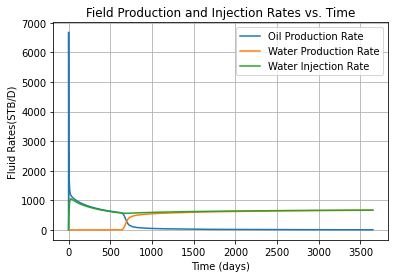

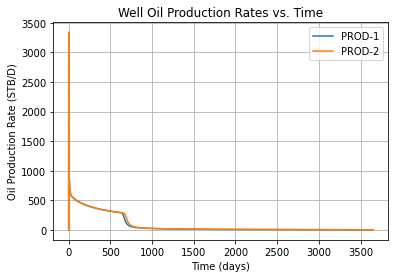

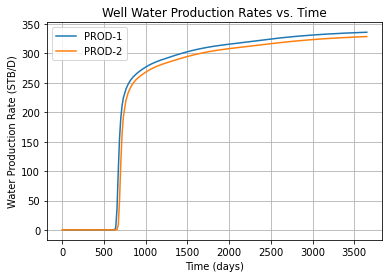

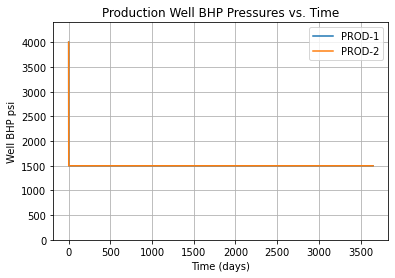

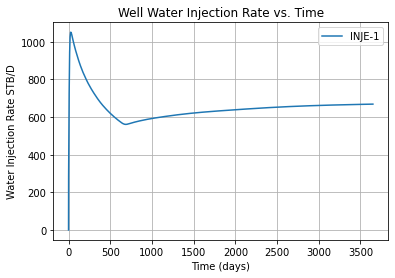

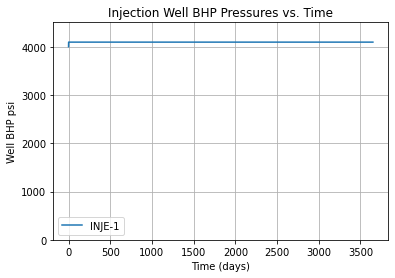

In [106]:
# Set the HTTP response parameters
response = requests.post(DJANGO_SERVER_API, data={'project_id':project_id, 'input_data': str(input_data)})
if response.status_code == 200:
    print('Success: Remote simulation job completed')
    response_json = response.json()
    #print_json(response_json)
    sim_results = response_json[0]      
    make_plots(sim_results)
else:
    
    print('Failed: Remote simulation job failed')

# Analysis of multiple (serial) HTTP requests

Above we have performed a single remote simulation. Here we are going to perform multiple serial HTTP request to the remote server using the same project_id and input data as above. We are going to consider two approaches.

In the first case (hereafter **Case 1**), we are testing the application servers running natively on the same machine (i.e., launched on a Linux shell). In the second case (hereafter **Case 2**), we first create a docker image of the application and then run the application server as a docker container. In the docker container case, we map the port in the container to the same port on the host as in **Case 1**. 

Another aim of this test is to compare the performance of the requests and the duration of each request in the application servers.

In both cases we perform several HTTP requests serially and we create performance plots for tracking the duration of the requests/tasks in the different tiers (server and application)

## Set the number of serial calls to make

In [112]:
# set the number of calls: 0 disables making the calls again
num_calls = 50

## Helper function to submit the serial requests

In [46]:
def submit_serial_requests(num_calls=num_calls):
    django_durations = np.zeros(num_calls)
    server_durations = np.zeros(num_calls)
    app_durations    = np.zeros(num_calls)
    for i in range(num_calls):
        # make one call
        response = requests.post(DJANGO_SERVER_API, data={'project_id':project_id, 'input_data': str(input_data)})
        results = response.json()
        # save the results
        django_durations[i] = results[0]['django_req_duration']
        server_durations[i] = results[0]['server_req_duration']
        app_durations[i]    = results[0]['job_duration']
        
    # create a pandas DataFrame
    df = pd.DataFrame({'Req Index': range(1,num_calls+1), 'Django Req Duration' : django_durations, 'AppServer Req Duration' : server_durations, 'App Job Duration' : app_durations})
    
    return df

## Case 1: Serial HTTP requests with application server running natively

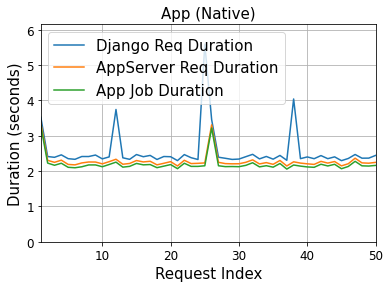

In [113]:
# Make the calls
df1 = submit_serial_requests(num_calls)
# create performance plot
make_performance_plot(df1, title='App (Native)', plot_filename=f"native_serial_request_{num_calls}_calls.png", data_filename=f"native_serial_request_{num_calls}_calls.csv")

## Case 2: Serial HTTP requests with application server running in a docker container
Note: I am creating the docker images required to perform the analyses in the section.

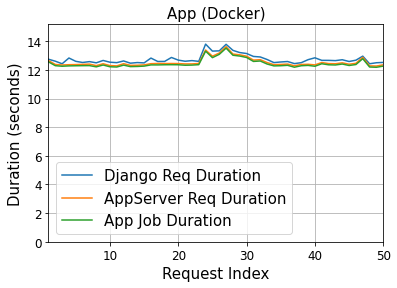

In [115]:
# Make the calls
df2 = submit_serial_requests(num_calls)
# create performance plot
make_performance_plot(df2, title='App (Docker)', plot_filename=f"docker_serial_request_{num_calls}_calls.png", data_filename=f"docker_serial_request_{num_calls}_calls.csv")

# Future work: Test performance with distributed servers

Next, we will perform similar analyses with the servers deployed on the cloud to simulate real application usage and repeat these serial calls to the Django and application servers. Additionally, we will stress test the ability application to handle multiple synchronous calls.